# 18.330 Problem set 4 (spring 2020)

## Submission deadline: 11:59pm on Tuesday, March 3

### Exercise 1: Summation two ways

Consider the problem of summing $N$ numbers:

$$
S = \sum_{n=1}^{N} x_n
$$
We will compare two different ways to do this with the built-in  `sum` function in Julia.

1. Implement the naive summation algorithm as `sum1`
    that takes in a vector `x` and sums the elements, using
    e.g. a `for` loop.

2. Implement the summation in a different way (`sum2`) by
    splitting the vector into two halves
    and calling the function recursively on each half.
    The base case when `x` is of length 1 just returns `x[1]`.
    For simplicity assume that `x` has a length that is a power
    of two.

    The recursive line of your implementation should look something like this:

    `return sum2(view(x, 1:nnew)) + sum2(view(x, nnew+1:n))`

    This is the recursive part. `nnew` is half the length of the input vector,
    `n/2` (you might want to use `div` to calculate this).
    While not specifically part of the course, the reason you need to use views
    is to prevent excessive memory allocations that slow down the code too
    much for this problem to work -- so please use them.

3. Use the built-in Julia `sum` function on `big.(x)` as the true value.
    Calculate the relative error of `sum1` and `sum2` as
    the length of `x` is varied from $2^5$ to $2^{20}$.
    Make a plot of relative error vs. length.
    What do you see? Which plot function would you use only given this
    plot?

4. How do the speeds compare? Using the `@belapsed` function, eg.

    ```jl
    sum1_time = `@belapsed sum1($x)`
    ```

    benchmark the two sum functions that you have defined and plot the run times as a
    function of length. Which function would you use only given this plot?

5. If everything went according to plan you should have obtained
    different answers for [3] and [4]. How can we remedy this
    situation? Recursing all the way down to a base case of length $1$
    is very inefficient, since there is a time overhead for each
    function invocation. From your error plot, though, you should be
    able to see that the errors of your implementations
    only start diverging once `x` reaches
    a certain length, say `2^10` (although you can play with this
    number).

    Write a new function `sum3` that uses recursion but that
    calls `sum1` after `x` is sufficiently short, i.e. changing
    the base case specification in your `sum2` function.

    [This a technique that we will see repeatedly with
    other recursive algorithms, such as cache-efficient
    matrix multiplication and the FFT algorithm.]


6. Calculate the relative error and run time for this
    new function and also the built-in Julia `sum` function as
    in [3, 4] and add it the plots you made there. Which function
    would you use now? Your `sum3` implementation is the same way
    that julia calculates sums bit with more optimizations.

Hopefully this problem has shown that thinking about errors
and how you implement even the simplest algorithms,
such as summation, is important if you want to have both
performance and accuracy. Naive implementations can be
dangerous!

In [61]:
using Test
using Plots
using BenchmarkTools

In [2]:
function rela_error(x, x̂)
    return abs((x̂ - x)/x)
end
@test rela_error(1, 1.5) == 0.5

Test Passed

In [7]:
function sum1(x)
    sum = 0
    for i in 1:length(x)
        sum += x[i]
    end
    return sum
end
@test sum1([1, 2, 3]) == 6

Test Passed

In [11]:
function sum2(x)
    n = length(x)
    if n == 1
        return x[1]
    end
    nnew = Int(n/2) 
    return sum2(view(x, 1:nnew)) + sum2(view(x, nnew+1:n))
end
@test sum2([1, 1]) == 2
#@test sum2([1, 2, 3, ]) == 6

Test Passed

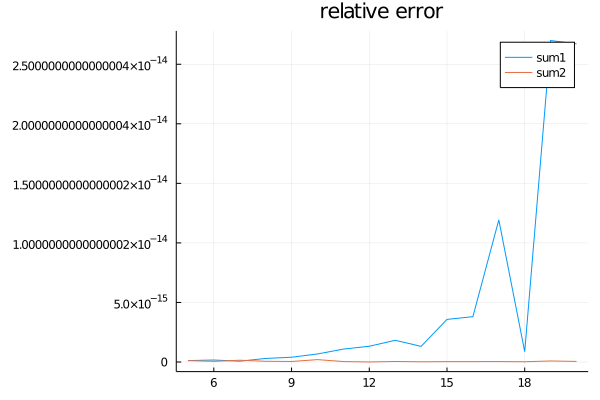

In [55]:
error_1 = []
error_2 = []
for i in 5:20
    x = rand(2^i)
    truth = sum(big.(x))
    push!(error_1, rela_error(truth, sum1(x)))
    push!(error_2, rela_error(truth, sum2(x)))
end

plot(collect(5:20), error_1, label="sum1")
plot!(collect(5:20), error_2, label="sum2")
title!("relative error")

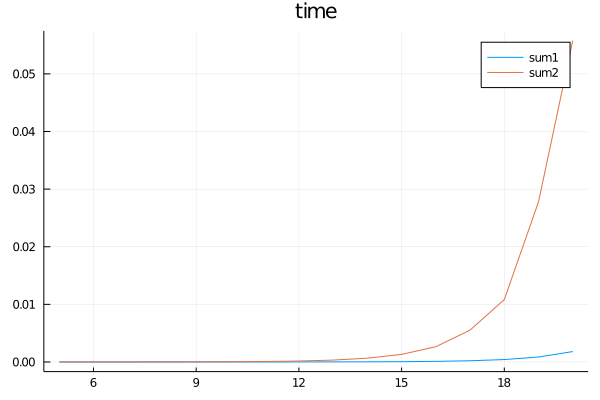

In [67]:
time_1 = []
time_2 = []

for i in 5:20
    x = rand(2^i)
    push!(time_1, @belapsed sum1($x))
    push!(time_2, @belapsed sum2($x))
end
plot(collect(5:20), time_1, label="sum1")
plot!(collect(5:20), time_2, label="sum2")
title!("time")

In [72]:
function sum3(x)
    n = length(x)
    if n <= 2^9 
        return sum1(x)
    else
        nnew = Int(n/2) 
        return sum3(view(x, 1:nnew)) + sum3(view(x, nnew+1:n))
    end
end

sum3 (generic function with 1 method)

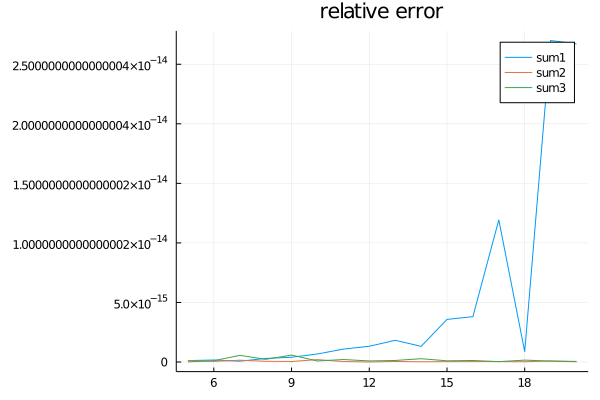

In [73]:
error_3 = []
for i in 5:20
    x = rand(2^i)
    truth = sum(big.(x))
    push!(error_3, rela_error(truth, sum3(x)))
end
plot(collect(5:20), error_1, label="sum1")
plot!(collect(5:20), error_2, label="sum2")
plot!(collect(5:20), error_3, label="sum3")
title!("relative error")

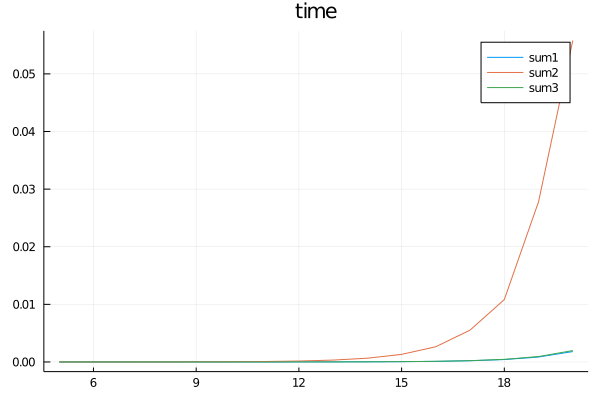

In [74]:
time_3 = []
for i in 5:20
    x = rand(2^i)
    push!(time_3, @belapsed sum3($x))
end
plot(collect(5:20), time_1, label="sum1")
plot!(collect(5:20), time_2, label="sum2")
plot!(collect(5:20), time_3, label="sum3")
title!("time")

#### Exercise 2: Conditioning of a problem and stability of an algorithm

Consider the problem to calculate

$$\phi(x) = \sqrt{1 + x} - 1$$

close to $x = 0$.

1. Calculate the relative condition number $\kappa_\phi(x)$.

2. Is the problem well conditioned near $x = 0$?

3. Consider the obvious algorithm by breaking up the formula into its simplest
    pieces. Thinking about it as this series of
    algorithmic steps, calculate the condition number of each step for $x$ near $0$.
    Which is the problematic step?

4. By using an algebraic manipulation, find an alternative
    algorithm to evaluate the function which is "stable", i.e. which does not
    introduce extra numerical error in this way.

5. Implement both the obvious algorithm and your better algorithm. Take the
    true value of $\phi$ to be `ϕ(big(x))` and calculate the relative error of
    both algorithms for different values of $x$ as it decreases toward $0$.
    Plot the errors as a function of $x$ on the same axes. Is your new algorithm
    better?

#####  calulate the relative condition number $\kappa_\phi(x)$
$\kappa_\phi(x) = |\frac{x\phi'(x)}{\phi(x)}|= \frac{x}{2\sqrt{1+x}}\frac{1}{\sqrt{1+x}-1} = \frac{x(\sqrt{1+x}+1)}{2\sqrt{1+x}x} = \frac{\sqrt{1+x}+1}{2\sqrt{1+x}} = \frac{1}{2} + \frac{1}{2\sqrt{1+x}}$ 

From above we can see that the problem is well conditioned near x=0

##### define $\phi_1(x) = \sqrt{1+x}, \phi_2(x) = x - 1, then, \phi(x) = \phi_2(\phi_1(x))$
$\kappa_{\phi_1} = \frac{1}{2} - \frac{1}{2(1+x)}$   $x \rightarrow 0$

$\kappa_{\phi_2} = 1 + \frac{1}{x-1}$   $x \rightarrow 1$

we can see that the second operation (subtract) is problematic

##### $\phi(x) = \frac{\sqrt{1+x} + 1}{x}$

In [87]:
function naive(x)
    return sqrt(x+1) - 1
end
function stable(x)
    return x/(sqrt(1+x) + 1)
end

stable (generic function with 1 method)

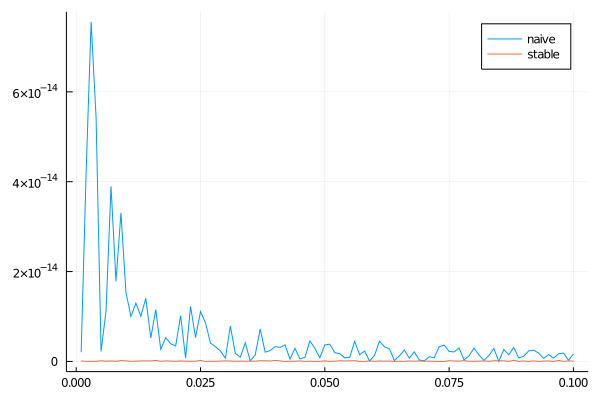

In [90]:
error_1 = []
error_2 = []
xs = range(0.001, 0.1, length=100)
for x in xs
    true_val = naive(big(x))
    push!(error_1, rela_error(true_val, naive(x)))
    push!(error_2, rela_error(true_val, stable(x)))
end
plot(xs, error_1, label="naive")
plot!(xs, error_2, label="stable")

In [ ]:
from plot above we can see that the second implementation is more stable

#### Exercise 3: Conditioning of polynomial roots

Consider a degree-$n$ polynomial
$p(x) = a_0 + a_1 x + \cdots + a_n x^n$.

1. Show that the condition number of the problem of finding a root $r$
    of this polymomial when the leading coefficient $a_n$ is varied is

    $$\kappa = \left| \frac{a_n r^{n-1}}{p'(r)} \right|$$

    Hint: To do this use e.g. implicit differentiation on the equation that
    the root $r$ satisfies.

2. Consider the (in)famous Wilkinson polynomial

    $p(x) = (x - 1) (x - 2) \cdots (x - 20)$.

    Calculate the coefficients of the polynomial using e.g.
    your `Polynomial` type from a previous problem set or the
    `Polynomials.jl` package. Note that you will need to use
    `Int128` or `BigInt`.

3. Calculate, e.g. analytically or using automatic differentiation,
    the condition number of each root of the polynomial. Which roots are
    well-conditioned and which are ill-conditioned?

4. Use e.g. the `roots` function from the `PolynomialRoots.jl` package
    to calculate the roots of $p(x)$. Are they correct?

    Now perturb a single coefficient of $p(x)$ by `randn()*2.0^(-23)`` and find
    and plot the roots on the same graph. Repeat this 50 times to see
    a visual representation of the unstable nature of polynomial root finding.

    Does the result agree with what you calculated in [3]?



In [104]:
import Pkg; Pkg.add("PolynomialRoots")
using PolynomialRoots

  Resolving package versions...
  Installed PolynomialRoots ─ v1.0.0
   Updating `~/.julia/environments/v1.4/Project.toml`
  [3a141323] + PolynomialRoots v1.0.0
   Updating `~/.julia/environments/v1.4/Manifest.toml`
  [3a141323] + PolynomialRoots v1.0.0
┌ Info: Precompiling PolynomialRoots [3a141323-8675-5d76-9d11-e1df1406c778]
└ @ Base loading.jl:1260


In [93]:
using Polynomials

##### calculate the condition number
Because r is a root of $p(x)$, so we get $p(r) = 0$, differentiate the both sides with respect to $a_n$

$$p'(r)\frac{\partial{r}}{a_n} + r^n = 0$$

$$\kappa = \left|\frac{a_n\frac{\partial{r}}{a_n}}{r}\right| = \left| \frac{a_n r^{n-1}}{p'(r)} \right| $$

In [119]:
function κ(p::Polynomial, r)
    return abs(p[end]*r^(length(p)-2)/derivative(p)(r))
end

κ (generic function with 2 methods)

In [141]:
big(2)

2

In [182]:
p = one(Polynomial{Float64})
for i in 1:20
    p *= Polynomial([-i, 1])
end
conditions = []
for i in 1:20
    push!(conditions, κ(p, i))
end
conditions

20-element Array{Any,1}:
      8.220635246624607e-18
      8.188962783177569e-11
      1.6338242156173811e-6
      0.002189621243314077
      0.6077417904145898
     58.24854485769611
   2542.3955726075815
  59700.06749584586
 839046.470320205
      6.419268005519356e6
      4.411828827902369e6
      3.664450347860649e6
      1.910095176658093e6
  98644.3303167057
 439569.16315275215
      0.0
  20959.019093143877
  12577.906053125129
    992.384700927269
     14.300657373353008

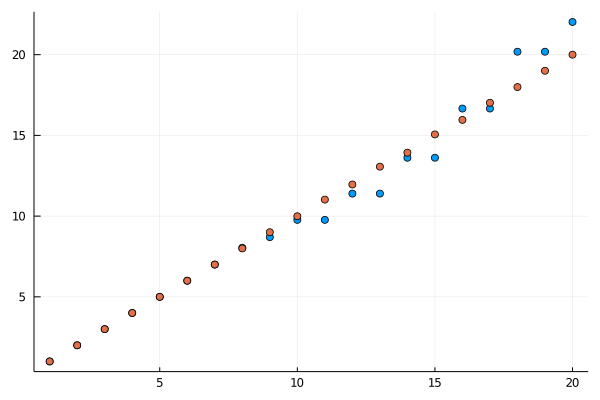

In [194]:
ϵ = randn()*2.0^(-23)
p1 = one(Polynomial{Float64})
for i in 1:20
    p1 *= Polynomial([-i, 1])
end
p1[end] += ϵ
scatter(real.(roots(p1)), legend=false)
scatter!(roots(p))



#### Exercise 4: Lagrange interpolation

1. Given nodes $t_i$, write a function to
    calculate the Lagrange cardinal functions $\ell_k(x)$ that satisfies
    $\ell_k(t_i) = [i = k]$ (remember $[i=k]$ is 0 unless $i=k$).
    Your function should take in a vector `t`, a value `x` and the index `k`
    and return the value of $\ell_k(x)$. What is the operation count for
    calculating the cardinal function?

2. Write a function to calculate the Lagrange interpolant in
    nodes $t_i$ with data $y_i$ at the point $x$ using your lagrange cardinal
    function from [1]. What is the operation count for calculating the Lagrange
    interpolant?

3. Find the Lagrange interpolant to the function $\exp(x)$ sampled
    at $N + 1$ equally spaced points in the interval $[-1, 1]$. Make a plot
    of the interpolant over this interval when $N = 10$. Also add a plot of
    $\exp(x)$ using the built in function and a scatter plot of the interpolating
    points. Do you see what you expect.

4. Calculate numerically the error in the interpolant compared to the function
    $\exp(x)$ by sampling at, say, 100 points
    in the interval and taking the maximum error.
    How does the error vary with the degree of the interpolant?

5. Consider the function $f(x) = \frac{1}{1 + 25x^2}$ on the interval $[-1, 1]$.
    What happens as you increase the number of equally-spaced points?
    Make an interactive visualization.
    This is known as the **Runge phenomenon**

6. Instead, interpolate at the **Chebyshev points**,
    $t_i := \cos(\theta_i)$, where $\theta_i$
    are equally-spaced angles between $0$ and $\pi$. Make another interactive visualization.
    You should find that now we do have convergence.
    Find numerically how the rate of convergence of the distance
     between the interpolant and the true function behaves as the number of points increases.
    This is known as **spectral convergence**.

In [207]:
function ℓ(t, k)
    mul = one(Polynomial) 
    for i in 1:length(t)
        if i == k
            continue
        end
        mul *= Polynomial([-t[i]/(t[k]-t[i]), 1/(t[k]-t[i])])
    end
    return mul
end

ℓ (generic function with 2 methods)

In [209]:
function Lagrange_interpolation(t, y)
    Lag = zero(Polynomial)
    for k in 1:length(t)
        Lag += y[k] * ℓ(t, k) 
    end
    return Lag
end

Lagrange_interpolation (generic function with 1 method)

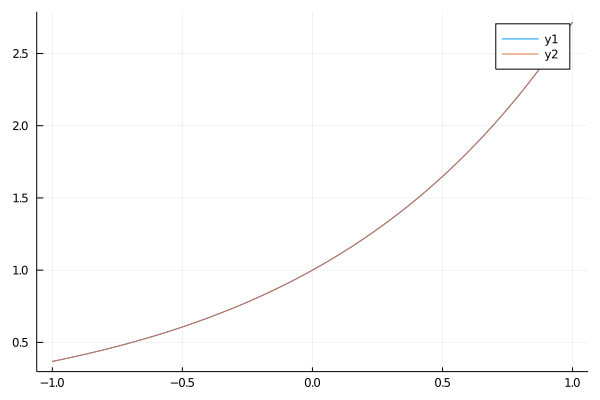

In [217]:
N = 10
t = range(-1, 1, length=N+1)
y = exp.(t)
xs = range(-1, 1, length=100)
ys = exp.(xs)
interp = Lagrange_interpolation(t, y)
yys = interp.(xs)
plot(xs, ys)
plot!(xs, yys)

In [255]:
function interp_error(f, N)
    t = range(-1, 1, length=N+1)
    y = f.(t)
    interp = Lagrange_interpolation(t, y)
    xs = range(-1, 1, length=100)
    ys = f.(xs)
    yys = interp.(xs)
    return maximum(abs.(yys-ys))
end

interp_error (generic function with 2 methods)

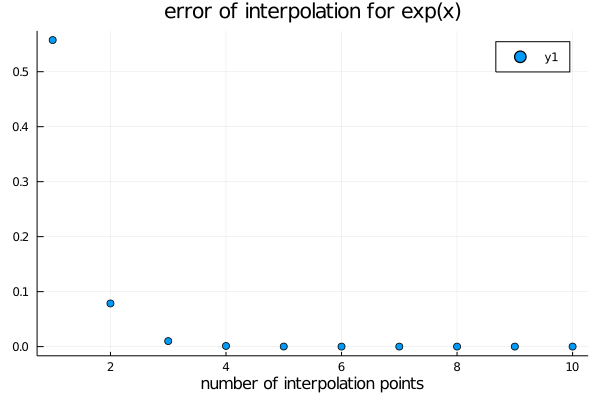

In [263]:
errors = interp_error.(exp, 1:10)
scatter(errors)
title!("error of interpolation for exp(x)")
xlabel!("number of interpolation points")

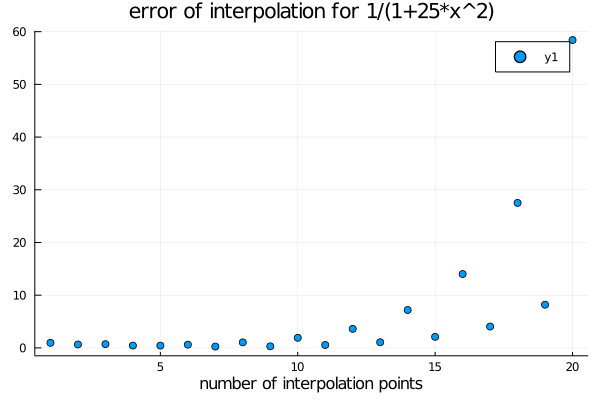

In [264]:
errors = interp_error.(x->1/(1+25*x^2), 1:20)
scatter(errors)
title!("error of interpolation for 1/(1+25*x^2)")
xlabel!("number of interpolation points")

In [268]:
function Chebyshev_interp_error(f, N)
    θ = range(0, π, length=N+1)
    t = cos.(θ)
    y = f.(t)
    interp = Lagrange_interpolation(t, y)
    xs = range(-1, 1, length=100)
    ys = f.(xs)
    yys = interp.(xs)
    return maximum(abs.(yys-ys))
end

Chebyshev_interp_error (generic function with 1 method)

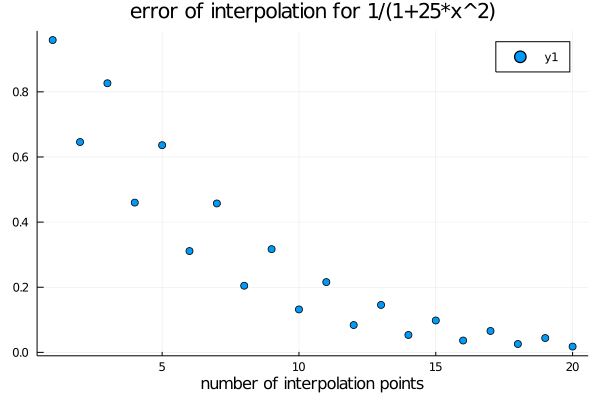

In [269]:
errors = Chebyshev_interp_error.(x->1/(1+25*x^2), 1:20)
scatter(errors)
title!("error of interpolation for 1/(1+25*x^2)")
xlabel!("number of interpolation points")

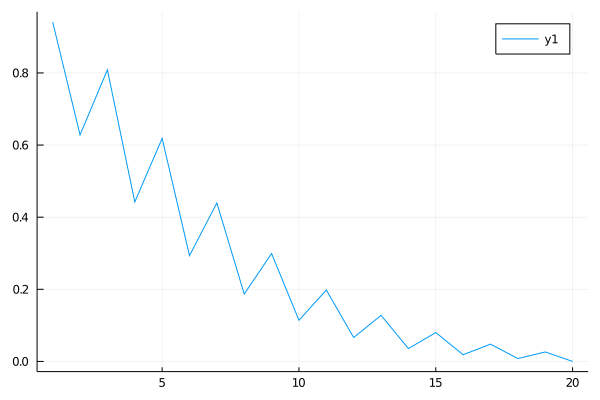

In [278]:
new_error = errors .- errors[end]
plot(new_error[1:end-1])